In [1]:
import numpy as np
import wfdb

def standardize_ecg(ecg_data, file_name):
    # Normalizar los valores de voltaje a un rango de 0 a 1
    ecg_data_normalized = (ecg_data - np.min(ecg_data)) / (np.max(ecg_data) - np.min(ecg_data))
    
    # Asegurarse de que todos los ECGs tengan la misma frecuencia de muestreo
    # Aquí puedes definir la frecuencia de muestreo deseada
    target_sampling_rate = 500  # Ejemplo de frecuencia de muestreo deseada en Hz
    
    # Si el archivo tiene una frecuencia de muestreo diferente, usar interpolación
    record = wfdb.rdsamp(file_name)
    original_sampling_rate = record[1]['fs']
    
    if original_sampling_rate != target_sampling_rate:
        num_samples = int(len(ecg_data_normalized) * target_sampling_rate / original_sampling_rate)
        # Interpolación de los datos normalizados
        x_old = np.linspace(0, len(ecg_data_normalized), len(ecg_data_normalized))
        x_new = np.linspace(0, len(ecg_data_normalized), num_samples)
        ecg_data_standardized = np.interp(x_new, x_old, ecg_data_normalized)
    else:
        ecg_data_standardized = ecg_data_normalized

    return ecg_data_standardized

In [2]:
import wfdb
import numpy as np
import os

directory = "./data/"
ECGs = []
lista = os.listdir(directory)
sorted_files = sorted(lista, key=lambda x: int(x.split('.')[0]))
for ecgfilename in sorted_files:
    if ecgfilename.endswith(".dat"):
        try:
            ecg = wfdb.rdsamp(directory + ecgfilename.split(".")[0])
            standardized_ecg = standardize_ecg(ecg[0], directory + ecgfilename.split(".")[0])  # Estandarizar
            ECGs.append(standardized_ecg) 
        except Exception as e:
            print(f"Error al leer el archivo {ecgfilename}: {e}")
ECGs = np.asarray(ECGs)
print(len(ECGs))


200


In [3]:
import wfdb
import numpy as np
import os

directoryAtletas = "./datos/"
ECGsAtletas = []
for ecgfilename in sorted(os.listdir(directoryAtletas)):
    if ecgfilename.endswith(".dat"):
        try:
            ecg = wfdb.rdsamp(directoryAtletas + ecgfilename.split(".")[0])
            standardized_ecg_atleta = standardize_ecg(ecg[0], directoryAtletas + ecgfilename.split(".")[0])  # Estandarizar
            ECGsAtletas.append(standardized_ecg_atleta) 
        except Exception as e:
            print(f"Error al leer el archivo {ecgfilename}: {e}")
ECGsAtletas = np.asarray(ECGsAtletas)
print(len(ECGsAtletas))

28


In [10]:
#etiquetas a considerar
#Clasificar los ECGs
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Leer las etiquetas de los ECGs, sin repetir
etiquetasConsiderar = []
etiquestasCardiologosAtletas = []
etiquetaRiesgoDeportista = []
for ecgfilename in sorted(os.listdir(directoryAtletas)):
    # Solo leer los archivos .hea desde el ath_001 hasta el ath_019
    if ecgfilename.endswith(".hea"):
        with open(directoryAtletas + ecgfilename) as f:
            lines = f.readlines()
            diagnoses = []
            for line in lines:
                riesgos = 0
                if line.startswith("#C:"):
                    etiqueta = line.split(":")[1].strip()
                    etiquetas = etiqueta.split(", ")
                    for etiqueta in etiquetas:
                        etiqueta = etiqueta.lower()
                        if etiqueta not in etiquetasConsiderar:
                            etiquetasConsiderar.append(etiqueta)
                        if("ecg" not in etiqueta):
                            diagnoses.append(etiqueta)
                        else:
                            etiquetaRiesgoDeportista.append(etiqueta)
                            
                        if(etiqueta == "right axis deviation"):
                            riesgos += 1
                        elif(etiqueta == "left axis deviation"):
                            riesgos += 1
                        elif(etiqueta == "left atrial enlargement"):
                            riesgos += 1
                    etiquestasCardiologosAtletas.append(diagnoses)
                    #if(riesgos > 1):
                       # etiquetaRiesgoDeportista.append("borderline ecg")
                    #else:
                     #   etiquetaRiesgoDeportista.append("normal ecg")

#impriir las etiquetas
print(etiquetasConsiderar)

#imprimir las etiquetas de los atletas
for i in range(len(etiquestasCardiologosAtletas)):
    print(f"Etiquetas del atleta {i + 1}: {etiquestasCardiologosAtletas[i]}")

print(etiquetaRiesgoDeportista)



['sinus arrhythmia', 'normal ecg', 'right axis deviation', 'normal sinus rhythm', 'left axis deviation', 'borderline ecg', 'sinus bradycardia', 'first degree av block', 'left ventricular hypertrophy', 'incomplete right bundle branch block', 'left atrial enlargement']
Etiquetas del atleta 1: ['sinus arrhythmia']
Etiquetas del atleta 2: ['sinus arrhythmia', 'right axis deviation']
Etiquetas del atleta 3: ['normal sinus rhythm', 'left axis deviation']
Etiquetas del atleta 4: ['normal sinus rhythm']
Etiquetas del atleta 5: ['sinus bradycardia', 'normal sinus rhythm', 'first degree av block']
Etiquetas del atleta 6: ['normal sinus rhythm', 'left ventricular hypertrophy']
Etiquetas del atleta 7: ['normal sinus rhythm']
Etiquetas del atleta 8: ['normal sinus rhythm', 'incomplete right bundle branch block']
Etiquetas del atleta 9: ['normal sinus rhythm', 'right axis deviation', 'first degree av block']
Etiquetas del atleta 10: ['normal sinus rhythm', 'left ventricular hypertrophy', 'left atria

In [20]:
#Filtrar datos para utilizar con la bd de deportistas
etiquestasCardiologos = []
ages = []
sexes = []
ECGsFiltrados = []
etiquetaRiesgo = []
for ecgfilename in sorted_files:
    if ecgfilename.endswith(".hea"):
        with open(directory + ecgfilename) as f:
            lines = f.readlines()
            diagnoses = []
            for line in lines:
                line = line.lower()
                if line.startswith("#<age>:"):
                    #si la edad es mayor a 50 años no se considera
                    if int(line.split(":")[1].strip()) <= 45:
                        ages.append(line.split(":")[1].strip())
                        try:
                            ecg = wfdb.rdsamp(directory + ecgfilename.split(".")[0])
                            standardized_ecg = standardize_ecg(ecg[0], directory + ecgfilename.split(".")[0])  # Estandarizar
                            ECGsFiltrados.append(standardized_ecg) 
                        except Exception as e:
                            print(f"Error al leer el archivo {ecgfilename}: {e}")
                    else:
                        break
                elif line.startswith("#<sex>:"):
                    sexes.append(line.split(":")[1].strip())
                #todas las linesa que esten despues de #<diagnoses> son las etiquetas de los cardiologos
                elif line.startswith("#<diagnoses>"):
                    riesgosBorderline = 0
                    riesgosAnormal = 0
                    for line in lines[lines.index("#<diagnoses>:\n")+1:]:
                        line = line.lower()
                        if line.startswith("#rhythm"):
                            #seleccionar solo despues del :
                            line = line.split(": ")[1].strip()                 
                            diagnoses.append(line.split(".")[0].lower())

                        elif line.startswith("#electric axis of the heart:"):
                            line = line.split(": ")[1].strip()
                            if line == "vertical." or line == "horizontal." or line == "normal.":
                                diagnoses.append("normal axis")
                            else:
                                diagnoses.append(line.split(".")[0].lower())
                                riesgosBorderline += 1
                        elif "degree" in line:
                            line = line.split(".")[0].strip()
                            line = line.split("#")[1].strip()
                            diagnoses.append(line)
                        elif "left ventricular" in line:
                            line = line.split(".")[0].strip()
                            line = line.split("#")[1].strip()
                            diagnoses.append(line.split(".")[0].lower())
                        elif "left atrial " in line:
                            line = line.split("#")[1].strip()
                            diagnoses.append(line.split(".")[0].lower())
                            riesgosBorderline += 1
                        elif "complete right bundle branch block" in line:
                            line = line.split("#")[1].strip()
                            if(line == "complete right bundle branch block."):
                                riesgosBorderline += 1
                            diagnoses.append(line.split(".")[0].lower())
                        elif "right atrial " in line:
                            line = line.split("#")[1].strip()
                            diagnoses.append(line.split(".")[0].lower())
                            riesgosBorderline += 1
                        elif "ischemia" in line:
                            diagnoses.append("ischemia")
                            riesgosAnormal += 1
                        #else: 
                            #diagnoses.append(line.split(".")[0].lower())            
                    etiquestasCardiologos.append(diagnoses)

                    if(riesgosAnormal > 0):
                        etiquetaRiesgo.append("anormal ecg")
                    elif(riesgosBorderline >1):
                        etiquetaRiesgo.append("borderline ecg")
                    else:
                        etiquetaRiesgo.append("normal ecg")

                    

# Print parsed data
print(f"Ages: {ages}")
print(f"Sexes: {sexes}")

#cantidad de edades menores de 50 años
cantidadEdades = 0
for i in range(len(ages)):
    if int(ages[i]) <= 45:
        cantidadEdades += 1
print(f"La cantidad de edades menores a 45 años es: {cantidadEdades}")


#imprimir solo los que no tienen la eitqueta '#Rhythm: Sinus rhythm.'
for i in range(len(etiquestasCardiologos)):
    print(f"ECG {i} tiene las siguientes etiquetas: {etiquestasCardiologos[i]}")

print(etiquetaRiesgo)

print(len(ECGsFiltrados))
print(len(etiquetaRiesgo))
        


Ages: ['41', '30', '34', '34', '38', '27', '32', '45', '19', '41', '38', '41', '28', '44', '44', '40', '23', '26', '25', '18', '26', '26', '22', '19', '39', '43', '19', '15', '19', '26', '25', '35', '30', '27', '23', '22', '28', '23', '23', '20', '19', '30', '41', '20', '19', '20', '44', '35', '24', '39', '24', '18', '44', '34', '38', '11', '19', '42', '22', '17', '17', '19', '24', '42', '28', '28', '34', '38', '34']
Sexes: ['m', 'm', 'm', 'm', 'm', 'f', 'm', 'm', 'f', 'f', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'f', 'm', 'm', 'm', 'f', 'm', 'm', 'f', 'f', 'm', 'm', 'f', 'm', 'f', 'm', 'm', 'm', 'f', 'm', 'm', 'm', 'm', 'm', 'm', 'f', 'm', 'm', 'm', 'f', 'f', 'm', 'f', 'f', 'f', 'm', 'f', 'f', 'm', 'm', 'f', 'f', 'f', 'f', 'm', 'm', 'f', 'm', 'f', 'f', 'f', 'f']
La cantidad de edades menores a 45 años es: 69
ECG 0 tiene las siguientes etiquetas: ['sinus rhythm', 'left axis deviation', 'left atrial hypertrophy', 'left ventricular hypertrophy', 'ischemia', 'ischemia', 'ischemia']
ECG 1 

In [8]:
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw
import numpy as np
from collections import Counter

# Suponiendo que ECGsAtletas es una lista de todos los ECGs de los atletas
# y etiquetaRiesgo contiene las etiquetas correspondientes
diagnosticos_finales = {}

# Función para obtener el diagnóstico final basado en K vecinos más cercanos (KNN)
def diagnostico_dtw(distancias_diagnostico, k=3):
    # Obtener las k etiquetas de los k vecinos más cercanos
    vecinos_mas_cercanos = [etiqueta for _, etiqueta in distancias_diagnostico[:k]]
    # Contar las etiquetas más comunes
    diagnostico_mas_comun = Counter(vecinos_mas_cercanos).most_common(1)[0][0]
    return diagnostico_mas_comun

# Evaluar todos los ECGs de los atletas
for index, nuevo_ecg in enumerate(ECGsAtletas):
    distancias_diagnostico = []
    
    # Calcular las distancias DTW entre el nuevo ECG y los ECGs filtrados
    for i, ecg in enumerate(ECGsFiltrados):
        distancia, _ = fastdtw(nuevo_ecg, ecg, dist=euclidean)
        distancias_diagnostico.append((distancia, etiquetaRiesgo[i]))

    # Ordenar por distancia para obtener los ECGs más cercanos
    distancias_diagnostico.sort(key=lambda x: x[0])

    # Obtener el diagnóstico final utilizando K vecinos más cercanos (KNN)
    diagnostico_final = diagnostico_dtw(distancias_diagnostico, k=3)
    diagnosticos_finales[f'Atleta_{index}'] = diagnostico_final
    print(f"Diagnóstico del ECG del Atleta {index}: {diagnostico_final}")

# Si deseas guardar los diagnósticos en un archivo, puedes usar lo siguiente:
import json

# Guardar los diagnósticos en un archivo JSON
with open('diagnosticos_ecgs.json', 'w') as f:
    json.dump(diagnosticos_finales, f)


Diagnóstico del ECG del Atleta 0: normal ecg
Diagnóstico del ECG del Atleta 1: normal ecg
Diagnóstico del ECG del Atleta 2: normal ecg
Diagnóstico del ECG del Atleta 3: anormal ecg
Diagnóstico del ECG del Atleta 4: normal ecg
Diagnóstico del ECG del Atleta 5: normal ecg
Diagnóstico del ECG del Atleta 6: normal ecg
Diagnóstico del ECG del Atleta 7: normal ecg
Diagnóstico del ECG del Atleta 8: borderline ecg
Diagnóstico del ECG del Atleta 9: borderline ecg
Diagnóstico del ECG del Atleta 10: normal ecg
Diagnóstico del ECG del Atleta 11: normal ecg
Diagnóstico del ECG del Atleta 12: normal ecg
Diagnóstico del ECG del Atleta 13: normal ecg
Diagnóstico del ECG del Atleta 14: normal ecg
Diagnóstico del ECG del Atleta 15: normal ecg
Diagnóstico del ECG del Atleta 16: normal ecg
Diagnóstico del ECG del Atleta 17: normal ecg
Diagnóstico del ECG del Atleta 18: normal ecg
Diagnóstico del ECG del Atleta 19: normal ecg
Diagnóstico del ECG del Atleta 20: normal ecg
Diagnóstico del ECG del Atleta 21: 

In [17]:
#matriz de confusion de los atletas
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

import json
# Cargar etiquetas predichas
with open('diagnosticos_ecgs.json', 'r') as f:
    diagnosticos_finales = json.load(f)

# Definir las etiquetas verdaderas y predichas
etiquetas_verdaderas = etiquetaRiesgoDeportista
etiquetas_predichas = [diagnostico for diagnostico in diagnosticos_finales.values()]

#calcular la precision
precision = accuracy_score(etiquetas_verdaderas, etiquetas_predichas)
print(f"La precisión del modelo es: {precision}")





La precisión del modelo es: 0.8571428571428571


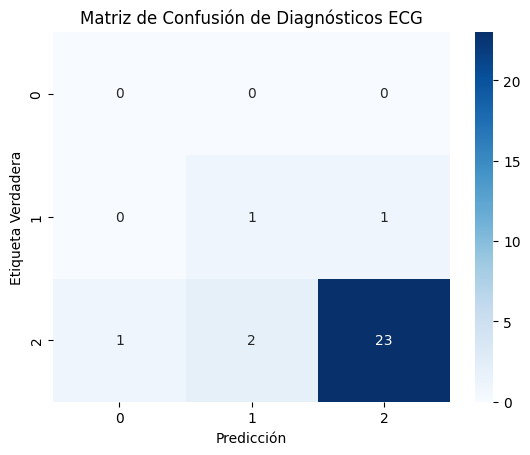

La precisión del modelo es: 0.8571428571428571


In [18]:
# Calcular y mostrar matriz de confusión
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

etiquetas_verdaderas = etiquetaRiesgoDeportista
etiquetas_predichas = [diagnostico for diagnostico in diagnosticos_finales.values()]

matriz_confusion = confusion_matrix(etiquetas_verdaderas, etiquetas_predichas)
sns.heatmap(matriz_confusion, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicción")
plt.ylabel("Etiqueta Verdadera")
plt.title("Matriz de Confusión de Diagnósticos ECG")
plt.show()

# Calcular y mostrar precisión
precision = accuracy_score(etiquetas_verdaderas, etiquetas_predichas)
print(f"La precisión del modelo es: {precision}")


In [34]:
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw
import numpy as np
from collections import Counter

# Suponiendo que ECGsAtletas es una lista de todos los ECGs de los atletas
# y etiquetaRiesgo contiene las etiquetas correspondientes
diagnosticos_finales = {}

# Función para obtener el diagnóstico final basado en K vecinos más cercanos (KNN)
def diagnostico_dtw(distancias_diagnostico, k=3):
    # Obtener las k etiquetas de los k vecinos más cercanos
    vecinos_mas_cercanos = [etiqueta for _, etiqueta in distancias_diagnostico[:k]]
    # Contar las etiquetas más comunes
    diagnostico_mas_comun = Counter(vecinos_mas_cercanos).most_common(1)[0][0]
    return diagnostico_mas_comun


# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(ECGsFiltrados, etiquetaRiesgo, test_size=0.2, random_state=42)

# Evaluar los ECGs de prueba
for index, nuevo_ecg in enumerate(X_test):
    distancias_diagnostico = []
    
    # Calcular las distancias DTW entre el nuevo ECG y los ECGs filtrados
    for i, ecg in enumerate(X_train):
        distancia, _ = fastdtw(nuevo_ecg, ecg, dist=euclidean)
        distancias_diagnostico.append((distancia, y_train[i]))

    # Ordenar por distancia para obtener los ECGs más cercanos
    distancias_diagnostico.sort(key=lambda x: x[0])

    # Obtener el diagnóstico final utilizando K vecinos más cercanos (KNN)
    diagnostico_final = diagnostico_dtw(distancias_diagnostico, k=3)
    diagnosticos_finales[f'ECG_{index}'] = diagnostico_final
    print(f"Diagnóstico del ECG {index}: {diagnostico_final}")

# Si deseas guardar los diagnósticos en un archivo, puedes usar lo siguiente:
import json

# Guardar los diagnósticos en un archivo JSON
with open('diagnosticos2_ecgs.json', 'w') as f:
    json.dump(diagnosticos_finales, f)


Diagnóstico del ECG 0: normal ecg
Diagnóstico del ECG 1: normal ecg
Diagnóstico del ECG 2: normal ecg
Diagnóstico del ECG 3: normal ecg
Diagnóstico del ECG 4: normal ecg
Diagnóstico del ECG 5: normal ecg
Diagnóstico del ECG 6: normal ecg
Diagnóstico del ECG 7: normal ecg
Diagnóstico del ECG 8: normal ecg
Diagnóstico del ECG 9: normal ecg
Diagnóstico del ECG 10: normal ecg
Diagnóstico del ECG 11: normal ecg
Diagnóstico del ECG 12: normal ecg
Diagnóstico del ECG 13: normal ecg


In [ ]:
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw
import numpy as np
from collections import Counter

# Suponiendo que ECGsAtletas es una lista de todos los ECGs de los atletas
# y etiquetaRiesgo contiene las etiquetas correspondientes
diagnosticos_finales = {}

# Función para obtener el diagnóstico final basado en K vecinos más cercanos (KNN)
def diagnostico_dtw(distancias_diagnostico, k=1, umbral_borderline=0.5):
    # Obtener las k etiquetas de los k vecinos más cercanos
    vecinos_mas_cercanos = [etiqueta for _, etiqueta in distancias_diagnostico[:k]]
    
    # Contar las etiquetas más comunes
    conteo_etiquetas = Counter(vecinos_mas_cercanos)
    etiqueta_mas_comun, frecuencia_mas_comun = conteo_etiquetas.most_common(1)[0]
    
    # Verificar si algún vecino cercano es "borderline ecg"
    if "borderline ecg" in vecinos_mas_cercanos:
        return "borderline ecg"
    elif "anormal ecg" in vecinos_mas_cercanos:
        return "anormal ecg"
    else:
        return etiqueta_mas_comun


# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(ECGsFiltrados, etiquetaRiesgo, test_size=0.2, random_state=42)

# Evaluar los ECGs de prueba
for index, nuevo_ecg in enumerate(X_test):
    distancias_diagnostico = []
    
    # Calcular las distancias DTW entre el nuevo ECG y los ECGs filtrados
    for i, ecg in enumerate(X_train):
        distancia, _ = fastdtw(nuevo_ecg, ecg, dist=euclidean)
        distancias_diagnostico.append((distancia, y_train[i]))

    # Ordenar por distancia para obtener los ECGs más cercanos
    distancias_diagnostico.sort(key=lambda x: x[0])

    # Obtener el diagnóstico final utilizando K vecinos más cercanos (KNN)
    diagnostico_final = diagnostico_dtw(distancias_diagnostico, k=3)
    diagnosticos_finales[f'ECG_{index}'] = diagnostico_final
    print(f"Diagnóstico del ECG {index}: {diagnostico_final}")

# Si deseas guardar los diagnósticos en un archivo, puedes usar lo siguiente:
import json

# Guardar los diagnósticos en un archivo JSON
with open('diagnosticos2_ecgs.json', 'w') as f:
    json.dump(diagnosticos_finales, f)


Diagnóstico del ECG 0: borderline ecg
Diagnóstico del ECG 1: normal ecg
Diagnóstico del ECG 2: normal ecg
Diagnóstico del ECG 3: normal ecg
Diagnóstico del ECG 4: normal ecg
Diagnóstico del ECG 5: normal ecg
Diagnóstico del ECG 6: borderline ecg


In [36]:
#matriz de confusion de los atletas
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

import json
# Cargar etiquetas predichas
with open('diagnosticos2_ecgs.json', 'r') as f:
    diagnosticos_finales = json.load(f)

# Definir las etiquetas verdaderas y predichas
etiquetas_verdaderas = y_test
etiquetas_predichas = [diagnostico for diagnostico in diagnosticos_finales.values()]

#calcular la precision
precision = accuracy_score(etiquetas_verdaderas, etiquetas_predichas)
print(f"La precisión del modelo es: {precision}")

#mostrar etiquetas verdaderas y predichas
print(f"Etiquetas verdaderas: {etiquetas_verdaderas}")
print(f"Etiquetas predichas: {etiquetas_predichas}")






La precisión del modelo es: 0.7857142857142857
Etiquetas verdaderas: ['normal ecg', 'anormal ecg', 'normal ecg', 'normal ecg', 'borderline ecg', 'normal ecg', 'borderline ecg', 'normal ecg', 'normal ecg', 'normal ecg', 'normal ecg', 'normal ecg', 'normal ecg', 'normal ecg']
Etiquetas predichas: ['normal ecg', 'normal ecg', 'normal ecg', 'normal ecg', 'normal ecg', 'normal ecg', 'normal ecg', 'normal ecg', 'normal ecg', 'normal ecg', 'normal ecg', 'normal ecg', 'normal ecg', 'normal ecg']


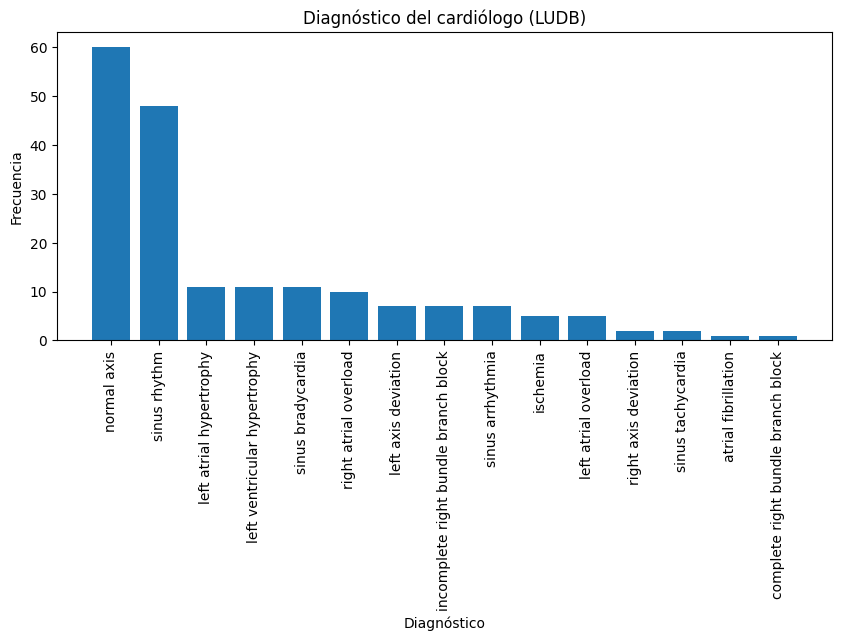

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter

# Flatten the diagnoses list and count frequency of unique diagnoses
all_diagnoses = [item for sublist in etiquestasCardiologos for item in sublist]
counter = Counter(all_diagnoses)
counter = dict(sorted(counter.items(), key=lambda item: item[1], reverse=True))

# Plot the most frequent diagnoses
plt.figure(figsize=(10, 4))
plt.bar(counter.keys(), counter.values())
plt.title('Diagnóstico del cardiólogo (LUDB)')
plt.xlabel('Diagnóstico')
plt.ylabel('Frecuencia')
plt.xticks(rotation=90)
plt.show()

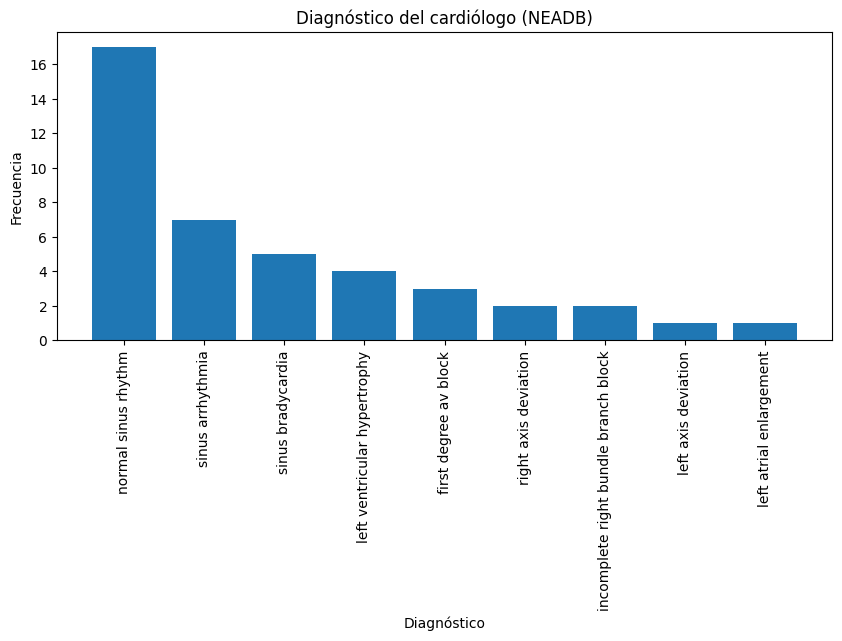

In [17]:
import matplotlib.pyplot as plt
from collections import Counter

# Flatten the diagnoses list and count frequency of unique diagnoses
all_diagnoses = [item for sublist in etiquestasCardiologosAtletas for item in sublist]
counter = Counter(all_diagnoses)
counter = dict(sorted(counter.items(), key=lambda item: item[1], reverse=True))

# Plot the most frequent diagnoses
plt.figure(figsize=(10, 4))
plt.bar(counter.keys(), counter.values())
plt.title('Diagnóstico del cardiólogo (NEADB)')
plt.xlabel('Diagnóstico')
plt.ylabel('Frecuencia')
plt.xticks(rotation=90)
plt.show()

ECG 6 es Borderline ECG
Etiquetas: ['sinus bradycardia', 'normal axis', 'right atrial overload', 'left atrial overload']
ECG 8 es Borderline ECG
Etiquetas: ['sinus rhythm', 'normal axis', 'left atrial overload']
ECG 9 es Borderline ECG
Etiquetas: ['sinus rhythm', 'left axis deviation', 'left ventricular hypertrophy']
ECG 10 es Borderline ECG
Etiquetas: ['sinus rhythm', 'left axis deviation', 'left atrial hypertrophy', 'left ventricular hypertrophy']
ECG 11 es Borderline ECG
Etiquetas: ['sinus rhythm', 'normal axis', 'left atrial hypertrophy']
ECG 12 es Borderline ECG
Etiquetas: ['sinus arrhythmia', 'right axis deviation', 'incomplete right bundle branch block']
ECG 14 es Borderline ECG
Etiquetas: ['sinus bradycardia', 'normal axis', 'left atrial hypertrophy', 'left ventricular hypertrophy']
ECG 15 es Borderline ECG
Etiquetas: ['sinus rhythm', 'left axis deviation', 'complete right bundle branch block', 'left atrial hypertrophy']
ECG 22 es Borderline ECG
Etiquetas: ['sinus rhythm', 'nor

<Figure size 1000x400 with 0 Axes>

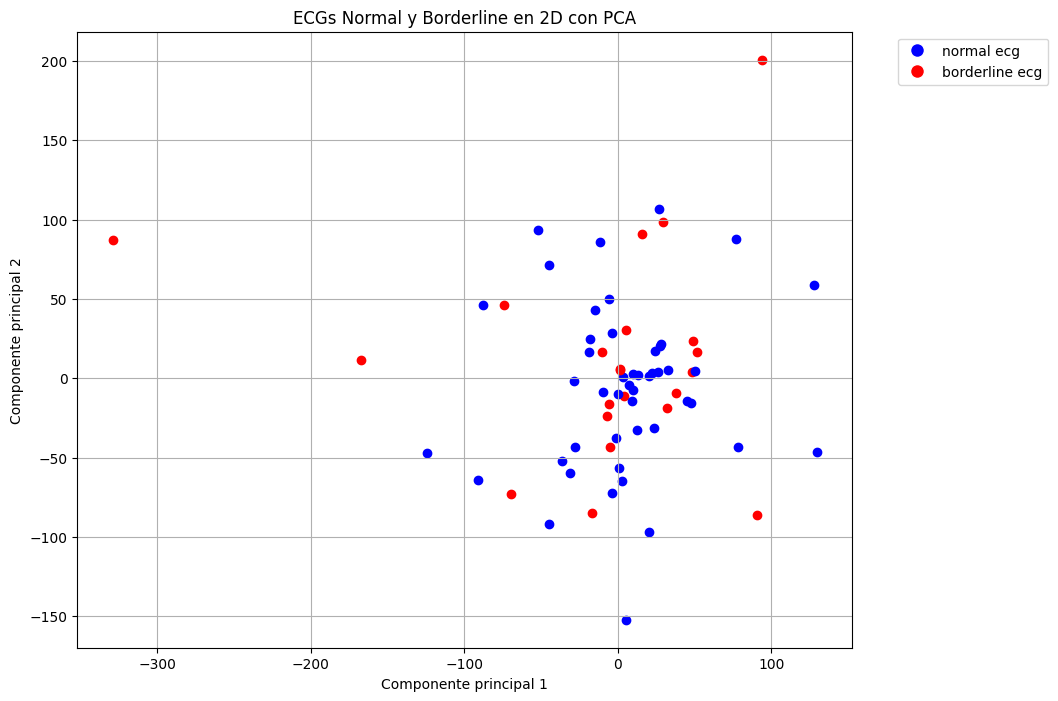

In [22]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.cluster import KMeans

# Normalizar los ECGs
scaler = StandardScaler()
normalized_ECGs = scaler.fit_transform([ecg.flatten() for ecg in ECGsFiltrados])

# Reducir la dimensionalidad de los ECGs
pca = PCA(n_components=2)
principal_components = pca.fit_transform(normalized_ECGs)

# Clasificar los ECGs por etiquetas
kmeans = KMeans(n_clusters=2)
kmeans.fit(principal_components)

# Graficar los ECGs en 2D con los clusters con leyenda de etiquetas
plt.figure(figsize=(10, 4))


# Graficar los ECGs en 2D con los clusters con leyenda de etiquetas
plt.figure(figsize=(10, 8))
# Crear un mapa de colores para las etiquetas
#azul para normal y naranja para borderline
label_color_map = {'normal ecg': 'blue', 'borderline ecg': 'red'}

# Graficar cada punto
for i, (x, y) in enumerate(principal_components):
    labels = etiquetaRiesgo[i]
    if 'normal ecg' in labels:
        plt.scatter(x, y, color='blue', label='normal ecg' if i == 0 else "")
    if 'borderline ecg' in labels:
        plt.scatter(x, y, color='red', label='borderline ecg' if i == 0 else "")
        print(f"ECG {i} es Borderline ECG")
        print(f"Etiquetas: {etiquestasCardiologos[i]}")

# Crear la leyenda
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=label_color_map[label], markersize=10) for label in label_color_map]
plt.legend(handles, label_color_map.keys(), bbox_to_anchor=(1.05, 1), loc='upper left')

plt.title('ECGs Normal y Borderline en 2D con PCA')
plt.xlabel('Componente principal 1')
plt.ylabel('Componente principal 2')
plt.grid()
plt.show()

69
200
ECG 0 es Borderline ECG
Etiquetas: ['sinus rhythm', 'left axis deviation', 'left atrial hypertrophy', 'left ventricular hypertrophy']
ECG 2 es Borderline ECG
Etiquetas: ['sinus bradycardia', 'normal axis', 'incomplete right bundle branch block']
ECG 6 es Borderline ECG
Etiquetas: ['sinus bradycardia', 'normal axis', 'right atrial overload', 'left atrial overload']
ECG 7 es Borderline ECG
Etiquetas: ['sinus bradycardia', 'left axis deviation', 'incomplete right bundle branch block', 'left atrial hypertrophy']
ECG 8 es Borderline ECG
Etiquetas: ['sinus rhythm', 'normal axis', 'left atrial overload']
ECG 9 es Borderline ECG
Etiquetas: ['sinus rhythm', 'left axis deviation', 'left ventricular hypertrophy']
ECG 10 es Borderline ECG
Etiquetas: ['sinus rhythm', 'left axis deviation', 'left atrial hypertrophy', 'left ventricular hypertrophy']
ECG 11 es Borderline ECG
Etiquetas: ['sinus rhythm', 'normal axis', 'left atrial hypertrophy']
ECG 12 es Borderline ECG
Etiquetas: ['sinus arrhyth

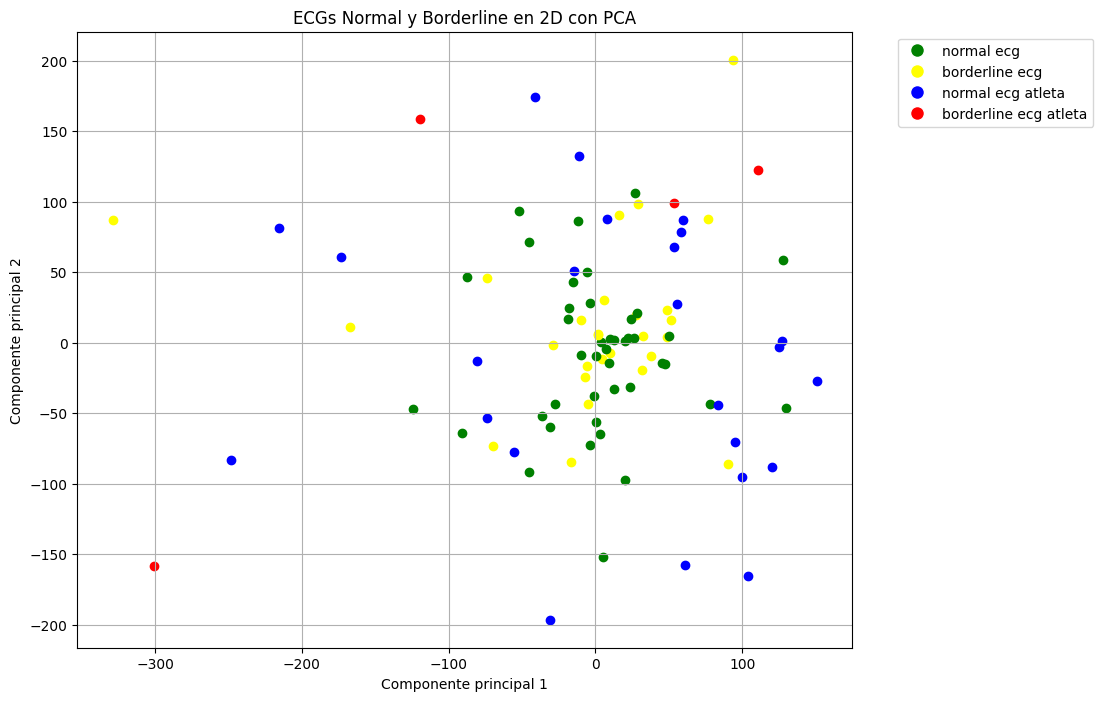

In [46]:
# Normalizar los ECGs
scaler = StandardScaler()
normalized_ECGs = scaler.fit_transform([ecg.flatten() for ecg in ECGsFiltrados])

# Reducir la dimensionalidad de los ECGs
pca = PCA(n_components=2)
principal_components = pca.fit_transform(normalized_ECGs)

# Normalizar los ECGs de los atletas
scalerD = StandardScaler()
normalized_ECGsD = scalerD.fit_transform([ecg.flatten() for ecg in ECGsAtletas])

# Reducir la dimensionalidad de los ECGs de atletas
pcaD = PCA(n_components=2)
principal_componentsD = pcaD.fit_transform(normalized_ECGsD)

# Clasificar los ECGs por etiquetas
kmeans = KMeans(n_clusters=2)
kmeans.fit(principal_components)

# Clasificar los ECGs de los atletas por etiquetas
kmeansD = KMeans(n_clusters=2)
kmeansD.fit(principal_componentsD)

# Graficar los ECGs en 2D con los clusters con leyenda de etiquetas
plt.figure(figsize=(10, 8))

# Crear un mapa de colores para las etiquetas
# verde para normal y amarillo para borderline
label_color_map = {'normal ecg': 'green', 'borderline ecg': 'yellow'}

print(len(etiquetaRiesgo))
print(len(ECGs))


# Graficar cada punto para los ECGs
for i, (x, y) in enumerate(principal_components):
    labels = etiquetaRiesgo[i]
    if 'normal ecg' in labels:
        plt.scatter(x, y, color='green', label='normal ecg' if i == 0 else "")
    if 'borderline ecg' in labels:
        plt.scatter(x, y, color='yellow', label='borderline ecg' if i == 0 else "")
        print(f"ECG {i} es Borderline ECG")
        print(f"Etiquetas: {etiquestasCardiologos[i]}")

# Graficar cada punto para los ECGs de los atletas
for i, (x, y) in enumerate(principal_componentsD):
    labels = etiquetaRiesgoDeportista[i]
    if 'normal ecg' in labels:
        plt.scatter(x, y, color='blue', label='normal ecg atleta' if i == 0 else "")
    if 'borderline ecg' in labels:
        plt.scatter(x, y, color='red', label='borderline ecg atleta' if i == 0 else "")
        print(f"ECG Atleta {i} es Borderline ECG")
        print(f"Etiquetas: {etiquestasCardiologosAtletas[i]}")

# Crear la leyenda para las 2 bases de datos
handles = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=10, label='normal ecg'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='yellow', markersize=10, label='borderline ecg'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='normal ecg atleta'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='borderline ecg atleta')
]
plt.legend(handles=handles, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.title('ECGs Normal y Borderline en 2D con PCA')
plt.xlabel('Componente principal 1')
plt.ylabel('Componente principal 2')
plt.grid()
plt.show()
